In [1]:
import delfi.distribution as dd
import matplotlib.pyplot as plt
import numpy as np
import time
import torch

from delfi.generator import Default
from delfi.simulator import Gauss
from delfi.summarystats import Identity
from helpers import *
from torch.autograd import Variable

%matplotlib inline

In [2]:
N = 20      # size of toy data

m = Gauss(noise_cov=np.sqrt(0.01))
p = dd.Uniform(lower=-2, upper=2)
s = Identity()
g = Default(model=m, prior=p, summary=s)

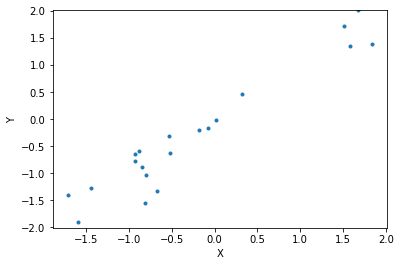

In [3]:
X, Y = g.gen(N, verbose=False);

X_var = Variable(torch.Tensor(X))
Y_var = Variable(torch.Tensor(Y))

plt.plot(X, Y, '.');
plt.xlabel('X');
plt.ylabel('Y');
ylim = max(abs(Y))
plt.ylim(-ylim, ylim);

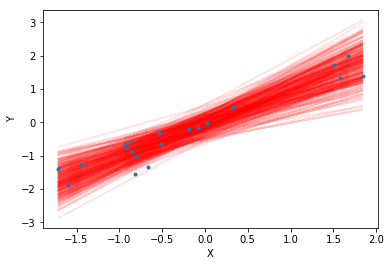

In [4]:
# posterior with bayesian linear regression

alpha = 0.01  # precision of isotropic Gaussian prior on weight
betam = 1.    # precision of model noise

m0 = 0.
S0 = 1/alpha*np.eye(2)
Phi = np.array([X.squeeze(), 
                np.ones((len(X)))]).T

SN = np.linalg.inv(alpha+betam*np.dot(Phi.T, Phi))
mN = betam*np.dot(SN, np.dot(Phi.T, Y))

for r in range(250):
    sampam = np.random.multivariate_normal(mN.squeeze(), SN, 1)
    plt.plot(X, np.dot(sampam.squeeze(), np.array([X, 1])), '-r', alpha=0.1)
plt.plot(X, Y, '.');
plt.xlabel('X');
plt.ylabel('Y');

In [5]:
model = MDN(svi=True, n_samples=100)

tic = time.time()
train(X, Y, model)
print('time elapsed : {:.2f}s'.format(time.time()-tic))

[epoch 0050] loss: 5.4822
[epoch 0100] loss: 4.5745
[epoch 0150] loss: 3.8722
[epoch 0200] loss: 3.0879
[epoch 0250] loss: 3.0963
[epoch 0300] loss: 2.6102
[epoch 0350] loss: 2.3508
[epoch 0400] loss: 2.4505
[epoch 0450] loss: 2.5792
[epoch 0500] loss: 2.4423
time elapsed : 13.31s


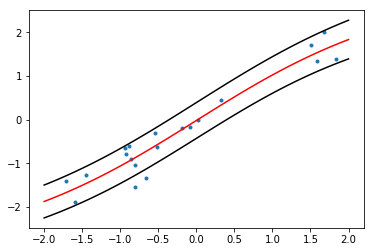

In [6]:
X_lin = np.linspace(-2, 2, 100).reshape(-1,1)
X_var_lin = Variable(torch.Tensor(X_lin))
Y_var = Variable(torch.Tensor(Y))

(out_alpha, out_sigma, out_mu) = model(X_var_lin, sample=False)

plt.plot(X, Y, '.')
plt.plot(X_lin, out_mu.data.numpy(), '-r');
plt.plot(X_lin, out_mu.data.numpy() + out_sigma.data.numpy(), '-k');
plt.plot(X_lin, out_mu.data.numpy() - out_sigma.data.numpy(), '-k');

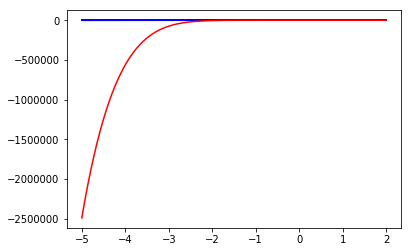

argmax C(θ)=0.429 with β=1.0


In [7]:
thetas = np.linspace(-5, 2, 500)

Cs = []
Lps = []

beta = 1.  # beta in [0,1]. 1=mean, 0=var
prior_mean = 0.
prior_var = 0.
obs = np.array([0.5])

for theta in thetas:   
    x_param = Variable(torch.Tensor(np.array([theta]).astype(np.float32)))
    y_var = Variable(torch.Tensor(obs))
    C, Lp = al_loss(x_param, obs, model, prior_mean, prior_var, beta=beta, frozen=True)
    
    C = C.data.numpy()
    Lp = Lp.data.numpy()
    
    Cs.append(C)
    Lps.append(Lp)
    
plt.plot(thetas, Lps, '-b', alpha=0.05);
plt.plot(thetas, Cs, '-r');
#plt.axis('off');
#plt.xlim([-5, 0.5])
plt.show();

print('argmax C(θ)={:.3f} with β={}'.format(thetas[np.nanargmax(Cs)], beta))
if np.any(np.isnan(Cs)):
    print('Warning: Cs contain NaNs')

In [8]:
tic = time.time()

t_init = np.array([0.0]).astype(np.float32)
x_param = nn.Parameter(torch.from_numpy(t_init))

optim = torch.optim.Adam([x_param], lr=0.1)

for i in range(100):
    optim.zero_grad()
    C, Lp = al_loss(x_param, obs, model, prior_mean, prior_var, beta=beta, frozen=True)
    C = -1*C
    C.backward()
    optim.step()

t_star = x_param.data.numpy()[0]

print('time elapsed : {:.2f}s'.format(time.time()-tic))
print('θ* = {:.2f}'.format(t_star))

time elapsed : 0.91s
θ* = 0.43


In [9]:
for i in range(25):
    t_init = np.array([0.0]).astype(np.float32)
    x_param = nn.Parameter(torch.from_numpy(t_init))
    optim = torch.optim.Adam([x_param], lr=0.1)
    for i in range(100):
        optim.zero_grad()
        C, Lp = al_loss(x_param, obs, model, prior_mean, prior_var, beta=beta, frozen=True)
        C = -1*C
        C.backward()
        optim.step()
    t_star = x_param.data.numpy()[0]
    print('new θ* = {:.2f}'.format(t_star))

    idx = np.arange(0, len(X), 1)
    np.random.shuffle(idx)

    N_REPS = 5
    X_retrain = np.repeat(np.array([[t_star]]), N_REPS, axis=0)
    Y_retrain = s.calc(m.gen([t_star], verbose=False, n_reps=N_REPS)[0])

    X_retrain = np.concatenate((X_retrain, X))
    Y_retrain = np.concatenate((Y_retrain, Y))
    X = X_retrain
    Y = Y_retrain

    #M = N
    #X_retrain = np.concatenate((X_retrain, X[idx[:M], :]))
    #Y_retrain = np.concatenate((Y_retrain, Y[idx[:M], :]))

    tic = time.time()
    train(X_retrain, Y_retrain, model)
    print('time elapsed : {:.2f}s'.format(time.time()-tic))

new θ* = 0.43
[epoch 0050] loss: 2.0615
[epoch 0100] loss: 1.9721
[epoch 0150] loss: 1.8373
[epoch 0200] loss: 2.2134
[epoch 0250] loss: 1.9684
[epoch 0300] loss: 1.8569
[epoch 0350] loss: 2.0720
[epoch 0400] loss: 1.9038
[epoch 0450] loss: 2.2686
[epoch 0500] loss: 1.8076
time elapsed : 13.01s
new θ* = 0.27
[epoch 0050] loss: 1.7077
[epoch 0100] loss: 1.8745
[epoch 0150] loss: 1.8299
[epoch 0200] loss: 1.7271
[epoch 0250] loss: 1.7856
[epoch 0300] loss: 1.5695
[epoch 0350] loss: 1.7095
[epoch 0400] loss: 1.5001
[epoch 0450] loss: 1.9060
[epoch 0500] loss: 1.6394
time elapsed : 19.30s
new θ* = 0.31
[epoch 0050] loss: 1.6938
[epoch 0100] loss: 1.6167
[epoch 0150] loss: 1.3258
[epoch 0200] loss: 1.2925
[epoch 0250] loss: 1.7733
[epoch 0300] loss: 1.4584
[epoch 0350] loss: 1.6740
[epoch 0400] loss: 1.5642
[epoch 0450] loss: 1.7961
[epoch 0500] loss: 1.7152
time elapsed : 20.50s
new θ* = 0.37
[epoch 0050] loss: 1.6451
[epoch 0100] loss: 1.6452
[epoch 0150] loss: 1.4230
[epoch 0200] loss: 1

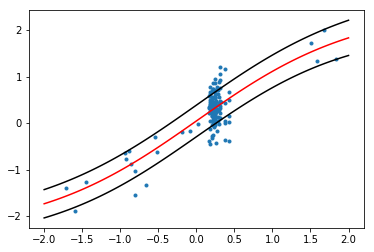

In [10]:
X_lin = np.linspace(-2, 2, 100).reshape(-1,1)
X_var_lin = Variable(torch.Tensor(X_lin))
Y_var = Variable(torch.Tensor(Y))

(out_alpha, out_sigma, out_mu) = model(X_var_lin, sample=False)

plt.plot(X, Y, '.')
plt.plot(X_lin, out_mu.data.numpy(), '-r');
plt.plot(X_lin, out_mu.data.numpy() + out_sigma.data.numpy(), '-k');
plt.plot(X_lin, out_mu.data.numpy() - out_sigma.data.numpy(), '-k');

In [11]:
X_lin = np.array([0.5]).reshape(-1,1)
X_var_lin = Variable(torch.Tensor(X_lin))
Y_var = Variable(torch.Tensor(Y))

(out_alpha, out_sigma, out_mu) = model(X_var_lin, sample=False)

In [13]:
out_mu

Variable containing:
 0.6083
[torch.FloatTensor of size 1x1]

In [12]:
out_sigma

Variable containing:
 0.3440
[torch.FloatTensor of size 1x1]